### This workbook tracks the monthly daily progress of XGS enablement vs Constructed Funded Living Units

##### This data pull is used to update the main historical enablement tracker
###### Please import a fresh view of powerbi construction funded details

In [1]:
# obtain three month window funding view (one month past, current month, one month future) from powerbi dashboard

# xgs enablement - get cumulative enablement at wire center; past month enablement; current month enablement

In [23]:
import os
import sys
import pandas as pd
import numpy as np
import cx_Oracle
cx_Oracle.init_oracle_client(lib_dir=r"C:\Oracle\instantclient_21_6")

ProgrammingError: Oracle Client library has already been initialized

In [47]:
#Import Funding data

Construction_details_base_df = pd.read_excel(r'FundingDetailsExport/Details_Export_Table.xlsx',sheet_name = 'Export')
Construction_Funding_df = Construction_details_base_df.copy()

In [49]:
# get relevant columns, drop rows with no wire center id
# 10/17/22 - get state column
Construction_Funding_df = Construction_Funding_df[["STATE","PRIMARY_WIRE_CENTER_ID", "PHASE_ECD_LOGIC", "PHASE_NUM_OF_LUS"]].dropna(subset=["PRIMARY_WIRE_CENTER_ID"])

In [50]:
# update date format - convert to str

Construction_Funding_df['PHASE_ECD_LOGIC'] = Construction_Funding_df['PHASE_ECD_LOGIC'].dt.to_period('M').astype(str)

In [54]:
# pivot data
# 10/17/22 - add STATE to pivot
Construction_pivot = Construction_Funding_df.groupby(by = ["STATE","PRIMARY_WIRE_CENTER_ID","PHASE_ECD_LOGIC"], as_index = False).sum().pivot(index=['STATE','PRIMARY_WIRE_CENTER_ID'], columns='PHASE_ECD_LOGIC')['PHASE_NUM_OF_LUS'].reset_index()

In [55]:
# fill nulls

Construction_pivot = Construction_pivot.fillna(0)

In [56]:
# check data

Construction_pivot.head()

PHASE_ECD_LOGIC,STATE,PRIMARY_WIRE_CENTER_ID,2022-09,2022-10,2022-11,2022-12
0,AZ,TCSNAZFW,0.0,0.0,160.0,554.0
1,AZ,TCSNAZMA,0.0,1277.0,1485.0,2969.0
2,AZ,TCSNAZRN,0.0,677.0,564.0,0.0
3,AZ,TCSNAZSW,0.0,163.0,282.0,479.0
4,CO,CLSPCOMA,577.0,653.0,0.0,514.0


In [57]:
# add grand total - manually adjust field names

Construction_pivot.loc[len(Construction_pivot.index)] = ['ALL',
                                                        'GRAND TOTAL',
                                                         Construction_pivot['2022-09'].sum(),
                                                         Construction_pivot['2022-10'].sum(),
                                                         Construction_pivot['2022-11'].sum(),
                                                         Construction_pivot['2022-12'].sum()]

In [58]:
Construction_pivot.tail()

PHASE_ECD_LOGIC,STATE,PRIMARY_WIRE_CENTER_ID,2022-09,2022-10,2022-11,2022-12
52,WA,STTLWA05,372.0,0.0,0.0,0.0
53,WA,STTLWASU,168.0,262.0,0.0,530.0
54,WA,TACMWALE,0.0,0.0,0.0,332.0
55,WA,VANCWA01,0.0,0.0,332.0,0.0
56,ALL,GRAND TOTAL,2765.0,22245.0,18055.0,39800.0


## Getting XGS enablement data

In [59]:
# FRAM001P
conn = cx_Oracle.connect(
    user="AD21236",
    password="L2022$Um",
    dsn="RACORAP08-SCAN.CORP.INTRANET/FRAM001P_PROD",
    encoding="UTF-8")

In [60]:
# qualifications data

qualifications_summary = """
            WITH QD AS (
            SELECT  
                    O.LUID --count distinct LU id's
                    ,O.STATE
                    ,O.WIRE_CENTER_ID AS PRIMARY_WIRE_CENTER_ID
                    ,O.ADDRESS
                    ,O.UNI_SERVICETYPE
                    ,O.OLT
                    ,O.TECH_TYPE
                    ,O.OLT_TYPE
                    ,O.FSAI
                    ,O.UNI_POLYGONID
                    ,O.UNI_STATUS
                    ,O.UNI_NDSJOBNUMBER
                    ,O.UNI_FWRKSJOBNUMBER
                    --,O.*
                    
            FROM    LQSMO.LU_QUAL_O O
            
            WHERE   ADDRESS <> '7599 S WHEELING CT'
                    AND (UNI_SERVICETYPE LIKE 'XGS%' 
                        OR TECH_TYPE LIKE 'XGS_PON' 
                        OR OLT_TYPE='ADTRAN-SDX6320-16-XGS-PON') 
                    AND uni_status='IN SERVICE'
                    
            )
            
            SELECT  0 as s
                    ,STATE
                    ,PRIMARY_WIRE_CENTER_ID
                    --,UNI_POLYGONID
                    ,count(distinct LUID) as cnt
                    
            FROM    QD
            
            GROUP BY
                    STATE
                    ,PRIMARY_WIRE_CENTER_ID
                    --,UNI_POLYGONID
            
            UNION ALL
            
            SELECT  1
                    ,'ALL'
                    ,'GRAND TOTAL'
                    --,'ALL'
                    ,count(distinct LUID)
                    
            FROM    QD
            
            ORDER BY 
                    s
                    ,STATE

                                """

qualifications_details = """
            WITH QD AS (
            SELECT  
                    O.LUID
                    ,O.STATE
                    ,O.WIRE_CENTER_ID AS PRIMARY_WIRE_CENTER_ID
                    ,O.UNI_NDSJOBNUMBER
                    ,O.UNI_POLYGONID
                    ,O.UNI_SERVICETYPE
                    ,O.UNI_STATUS
                    ,O.TECH_TYPE
                    ,O.FSAI
                    ,O.OLT_TYPE
                    ,O.ADDRESS
                    ,O.OLT
                    ,O.UNI_ECD
                    --O.*
                    
            FROM    LQSMO.LU_QUAL_O O
            
            WHERE   ADDRESS <> '7599 S WHEELING CT'
                    AND (UNI_SERVICETYPE LIKE 'XGS%' 
                        OR TECH_TYPE LIKE 'XGS_PON' 
                        OR OLT_TYPE='ADTRAN-SDX6320-16-XGS-PON') 
                    AND uni_status='IN SERVICE'
                    
            )
            
            SELECT  *
                    
            FROM    QD

                                """


qualifications_summary_df = pd.read_sql(qualifications_summary, con=conn)
qualifications_details_df = pd.read_sql(qualifications_details, con=conn)

C:\Users\AD21236\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\AD21236\Anaconda3\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [35]:
# check data

qualifications_summary_df

,S,STATE,PRIMARY_WIRE_CENTER_ID,CNT
0,0,AZ,TCSNAZRN,256
1,0,AZ,SPRSAZMA,259
2,0,AZ,TCSNAZMA,4573
3,0,AZ,TCSNAZCR,400
4,0,AZ,PHNXAZSO,850
5,0,AZ,PHNXAZNE,212
6,0,AZ,SPRSAZEA,295
7,0,AZ,TCSNAZFW,95
8,0,CO,ARVDCOMA,196
9,0,CO,DNVRCODC,166


In [61]:
# merge data
# 10/17/22 - update join to outer to get all construction funding. Add state to join

enablement_funding_details = qualifications_summary_df.merge(Construction_pivot, how = 'outer', on = ['STATE','PRIMARY_WIRE_CENTER_ID'])

In [62]:
enablement_funding_details

,S,STATE,PRIMARY_WIRE_CENTER_ID,CNT,2022-09,2022-10,2022-11,2022-12
0,0.0,AZ,TCSNAZRN,256.0,0.0,677.0,564.0,0.0
1,0.0,AZ,SPRSAZMA,259.0,NaN,NaN,NaN,NaN
2,0.0,AZ,TCSNAZMA,4573.0,0.0,1277.0,1485.0,2969.0
3,0.0,AZ,TCSNAZCR,400.0,NaN,NaN,NaN,NaN
4,0.0,AZ,PHNXAZSO,850.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
64,NaN,WA,FDWYWA01,NaN,0.0,0.0,0.0,487.0
65,NaN,WA,FRKSWAXA,NaN,0.0,0.0,0.0,201.0
66,NaN,WA,SPKNWAWH,NaN,0.0,0.0,0.0,210.0
67,NaN,WA,TACMWALE,NaN,0.0,0.0,0.0,332.0


In [63]:
# clean data

enablement_funding_details = enablement_funding_details.add_suffix('_CONSTRUCTION_FUNDED').rename(columns = {'S_CONSTRUCTION_FUNDED': 'S',
                                                                                'STATE_CONSTRUCTION_FUNDED': 'STATE',
                                                                                'PRIMARY_WIRE_CENTER_ID_CONSTRUCTION_FUNDED': 'PRIMARY_WIRE_CENTER_ID',
                                                                                'CNT_CONSTRUCTION_FUNDED': 'XGS_ENABLEMENT'})

In [64]:
enablement_funding_details = enablement_funding_details.drop(['S'], axis = 1)

In [65]:
# check data

enablement_funding_details.loc[enablement_funding_details['PRIMARY_WIRE_CENTER_ID'] == 'GRAND TOTAL']

,STATE,PRIMARY_WIRE_CENTER_ID,XGS_ENABLEMENT,2022-09_CONSTRUCTION_FUNDED,2022-10_CONSTRUCTION_FUNDED,2022-11_CONSTRUCTION_FUNDED,2022-12_CONSTRUCTION_FUNDED
35,ALL,GRAND TOTAL,33376.0,2765.0,22245.0,18055.0,39800.0


In [66]:
enablement_funding_details_save = enablement_funding_details.copy() # save to export

In [67]:
# state level summary

enablement_funding_state = enablement_funding_details.groupby(['STATE'], as_index = False).sum()

In [68]:
# add tab for tracking - manually update to current month

from datetime import datetime

enablement_funding_tracking = enablement_funding_state[['STATE','XGS_ENABLEMENT','2022-10_CONSTRUCTION_FUNDED']]

# add date column
enablement_funding_tracking['DATE'] = datetime.today().date()

C:\Windows\Temp\ipykernel_16780\1090022200.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  enablement_funding_tracking['DATE'] = datetime.today().date()


In [69]:
#manually update month name
enablement_funding_tracking = enablement_funding_tracking[['DATE','STATE','XGS_ENABLEMENT','2022-10_CONSTRUCTION_FUNDED']]

In [70]:
# export

import time

TodaysDate = time.strftime("%m%d%y")
excelfilename = "Output/" + TodaysDate +"_Monthly_Enablement_Funded_Tracker.xlsx"

with pd.ExcelWriter(excelfilename) as writer:
    enablement_funding_tracking.to_excel(writer, sheet_name='Tracking Data', index = False)
    enablement_funding_state.to_excel(writer, sheet_name='State_Summary', index = False)
    enablement_funding_details_save.to_excel(writer, sheet_name='WC_Summary', index = False)
    qualifications_details_df.to_excel(writer, sheet_name='LU_QUAL_O_Details', index = False)
    Construction_details_base_df.to_excel(writer, sheet_name='Construction_Funding_details', index = False)
    


## Create visualization - do not run until main tracker is populated manually

In [71]:
# Import Funding tracker
Funding_enablement_tracker_df = pd.read_excel(r'Enablement_Tracker_main.xlsx',sheet_name = 'Summary')

In [72]:
# check data
Funding_enablement_tracker_df


,DATE,STATE,XGS_ENABLEMENT,CURRENT_MONTH_CONSTRUCTION_FUNDED
0,2022-10-03,ALL,38340,31416
1,2022-10-03,AZ,12029,2409
2,2022-10-03,CO,5301,6033
3,2022-10-03,FL,13704,10665
4,2022-10-03,MN,4484,3104
...,...,...,...,...
77,2022-10-17,MN,5167,1502
78,2022-10-17,NV,0,83
79,2022-10-17,OR,74,178
80,2022-10-17,UT,810,1861


In [73]:
# update date type
Funding_enablement_tracker_df['DATE'] = pd.to_datetime(Funding_enablement_tracker_df['DATE']).dt.date

In [74]:
# plot only STATE = 'ALL'

Funding_enablement_tracker_df[Funding_enablement_tracker_df['STATE'] == 'ALL']

,DATE,STATE,XGS_ENABLEMENT,CURRENT_MONTH_CONSTRUCTION_FUNDED
0,2022-10-03,ALL,38340,31416
8,2022-10-04,ALL,37389,28649
16,2022-10-06,ALL,37747,27624
24,2022-10-07,ALL,37571,28346
32,2022-10-10,ALL,33437,27333
40,2022-10-11,ALL,33024,23900
48,2022-10-12,ALL,32997,23703
56,2022-10-13,ALL,32509,22244
64,2022-10-14,ALL,33032,22245
72,2022-10-17,ALL,33376,22245


In [75]:
# prep data for graph

graph_df = pd.melt(Funding_enablement_tracker_df.loc[Funding_enablement_tracker_df['STATE'] == 'ALL',['DATE','XGS_ENABLEMENT','CURRENT_MONTH_CONSTRUCTION_FUNDED']], id_vars=['DATE'], var_name=['type'])

In [76]:
graph_df

,DATE,type,value
0,2022-10-03,XGS_ENABLEMENT,38340
1,2022-10-04,XGS_ENABLEMENT,37389
2,2022-10-06,XGS_ENABLEMENT,37747
3,2022-10-07,XGS_ENABLEMENT,37571
4,2022-10-10,XGS_ENABLEMENT,33437
5,2022-10-11,XGS_ENABLEMENT,33024
6,2022-10-12,XGS_ENABLEMENT,32997
7,2022-10-13,XGS_ENABLEMENT,32509
8,2022-10-14,XGS_ENABLEMENT,33032
9,2022-10-17,XGS_ENABLEMENT,33376


In [77]:
"""
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# set graph space

fig2, ax2 = plt.subplots(figsize = (5, 5))

# set scale
sns.set(font_scale = 1.3)

# create graph

sns.barplot(x = "DATE", 
            y = 'value', 
            hue = 'type',
            data = graph_df,
            palette = 'magma',
            ax = ax2
           )

# graph cleanup

ax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles=handles, labels=['XGS Enablement','Construction Funded'])

ax2.set(xlabel = None, ylabel = None)
ax2.set_title('Monthly Enablement vs Construction Funded Tracker')

plt.show()
"""

'\nimport matplotlib.pyplot as plt\nimport matplotlib as mpl\nimport seaborn as sns\n\n# set graph space\n\nfig2, ax2 = plt.subplots(figsize = (5, 5))\n\n# set scale\nsns.set(font_scale = 1.3)\n\n# create graph\n\nsns.barplot(x = "DATE", \n            y = \'value\', \n            hue = \'type\',\n            data = graph_df,\n            palette = \'magma\',\n            ax = ax2\n           )\n\n# graph cleanup\n\nax2.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(\'{x:,.0f}\'))\n\nhandles, labels = ax2.get_legend_handles_labels()\nax2.legend(handles=handles, labels=[\'XGS Enablement\',\'Construction Funded\'])\n\nax2.set(xlabel = None, ylabel = None)\nax2.set_title(\'Monthly Enablement vs Construction Funded Tracker\')\n\nplt.show()\n'

In [78]:
# sort values, construction funded comes first, then xgs_enablement
graph_df = graph_df.sort_values(by = ['DATE','type'])

In [79]:
graph_df['DATE'] = pd.to_datetime(graph_df['DATE']).dt.date

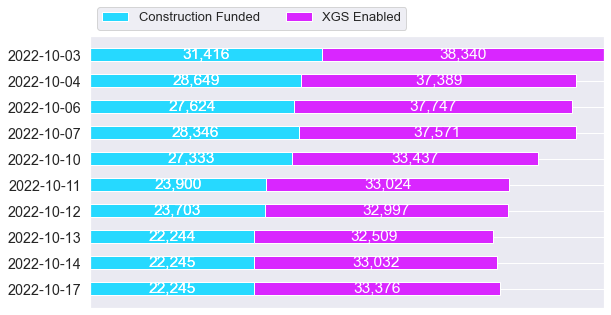

In [80]:
"""
Debug notes: update results to update date to string to avoid separated outputs

"""

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# set scale
sns.set(font_scale = 1.3)

# stacked percent

category_names = np.array(graph_df['type'].unique())
results = {str(k): list(v) for k, v in graph_df[['DATE','value']].groupby('DATE')['value']}


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['cool'](
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        container = ax.containers[0]
        for container in ax.containers:
            ax.bar_label(container, labels=[f'{x:,.0f}' for x in container.datavalues], label_type='center', color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small', labels=['Construction Funded','XGS Enabled'])

    return fig, ax


survey(results, category_names)
plt.show()